## 1. Imports

In [1]:
import os
os.chdir("..")

In [2]:
import json
from glob import glob

import cv2
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

## 2. Helper functions

In [3]:
def get_label_info(
    label,
    label_category,
    s_thr=32**2,
    l_thr=96**2,
    ul_thr=8**2,
    uh_thr=512**2
    ):

    bbox = label.get("box2d", None)
    label_name = label.get("category", "").replace(" ", "-")

    if not bbox:
        area = None
        is_small = is_medium = is_large = is_uncertain = False
        return label_name, bbox, area, is_small, is_medium, is_large, is_uncertain
    
    common_labels = label_category["common"]
    small_labels = label_category["small"]
    large_labels = label_category["large"]
    
    x1, y1, x2, y2 = bbox.values()
    area = (x2 - x1) * (y2 - y1)
    bbox = [x1, y1, x2, y2]

    is_small = (area < s_thr)
    is_medium = (s_thr < area < l_thr)
    is_large = (area > l_thr)
    is_possibly_uncertain_small = (area < ul_thr)
    is_possibly_uncertain_large = (area > uh_thr)
    
    is_uncertain = False
    if is_small and is_possibly_uncertain_small:
        # small, common and large objects; falling under area 8^2; `uncertain` must be set to `True`
        is_uncertain = True 
                    
    if is_large and is_possibly_uncertain_large:
        # large objects possibly cannot be one of small or common objects category
        is_uncertain = False if label_name in large_labels else True
                    
    return (
        label_name,
        bbox,
        area,
        is_small,
        is_medium,
        is_large,
        is_uncertain
    )

def iou(bbox1, bbox2):

    x1 = max(bbox1[0], bbox2[0])
    y1 = max(bbox1[1], bbox2[1])
    x2 = min(bbox1[2], bbox2[2])
    y2 = min(bbox1[3], bbox2[3])

    inter_w = max(0, x2 - x1)
    inter_h = max(0, y2 - y1)
    inter = inter_w * inter_h

    if inter == 0:
        return 0.0

    area1 = (bbox1[2] - bbox1[0]) * (bbox1[3] - bbox1[1])
    area2 = (bbox2[2] - bbox2[0]) * (bbox2[3] - bbox2[1])

    return inter / (area1 + area2 - inter)

def get_imagewise_counts(df, attribute):
    
    assert attribute in [
        "weather", "scene", "timeofday"
    ], "`attribute` must be one of ['weather', 'scene', 'timeofday']"
    
    df = df[['file_name', attribute]].drop_duplicates()

    attribute_data = sorted(df[attribute].unique().tolist())
    result = {
        "attribute": attribute,
        "data": attribute_data,
        "counts": []
    }
    
    for category in attribute_data:
        result["counts"].append(len(df[df[attribute] == category]))
        
    return result

def get_classwise_counts(df, attribute):

    assert attribute in [
        "weather", "scene", "timeofday"
    ], "`attribute` must be one of ['weather', 'scene', 'timeofday']"
    
    attribute_list = sorted(df[attribute].unique().tolist())

    unique_images = df[['file_name', 'label', attribute]].drop_duplicates()
    class_attribute_counts = unique_images.groupby(['label', attribute]).size().unstack(fill_value=0)

    class_attribute_counts = class_attribute_counts.reindex(columns=attribute_list, fill_value=0)
    
    return attribute_list, class_attribute_counts

def get_labelwise_counts(df, attribute):

    all_attributes =  [
        'label',
        'occluded',
        'truncated',
        'small',
        'medium',
        'large',
        'uncertain'
    ]
    assert attribute in all_attributes, f"`attribute` must be one of {all_attributes}"

    if attribute == "label":
        attribute_data = sorted(df[attribute].unique().tolist())
        result = {
            "attribute": attribute,
            "data": attribute_data,
            "counts": []
        }

        for category in attribute_data:
            result["counts"].append(len(df[df[attribute] == category]))
            
        return result

    df = df[df[attribute] == True]
    crops = df[['file_name', 'label', attribute]]
    crops_attribute_counts = crops.groupby(['label', attribute]).size().unstack(fill_value=0)
    crops_attribute_counts = crops_attribute_counts.reindex(columns=[True], fill_value=0)
    return crops_attribute_counts

def get_counts(df):
    
    # Image-Wise
    result_weather = get_imagewise_counts(df, attribute="weather")
    result_scene = get_imagewise_counts(df, attribute="scene")
    result_time_of_day = get_imagewise_counts(df, attribute="timeofday")

    # Class-Wise
    result_class_weather = get_classwise_counts(df, attribute="weather")
    result_class_scene = get_classwise_counts(df, attribute="scene")
    result_class_time_of_day = get_classwise_counts(df, attribute="timeofday")

    # Label-Wise
    result_label = get_labelwise_counts(df, attribute="label")
    result_label_occluded = get_labelwise_counts(df, attribute="occluded")
    result_label_truncated = get_labelwise_counts(df, attribute="truncated")
    result_label_small = get_labelwise_counts(df, attribute="small")
    result_label_medium = get_labelwise_counts(df, attribute="medium")
    result_label_large = get_labelwise_counts(df, attribute="large")
    result_label_uncertain = get_labelwise_counts(df, attribute="uncertain")
    
    return dict(
        image_wise=dict(
            weather=result_weather,
            scene=result_scene,
            time_of_day=result_time_of_day
        ),
        class_wise=dict(
            weather=result_class_weather,
            scene=result_class_scene,
            time_of_day=result_class_time_of_day
        ),
        label_wise=dict(
            all_labels=result_label,
            occluded=result_label_occluded,
            truncated=result_label_truncated,
            small=result_label_small,
            medium=result_label_medium,
            large=result_label_large,
            uncertain=result_label_uncertain,
        )
    )

def plot_count(data, save_path=None):
    plt.figure(figsize=(8, 6))
    plt.bar(data["data"], data["counts"])
    plt.xlabel(data["attribute"].title())
    plt.ylabel("Count")
    plt.title(f"Distribution by {data['attribute'].title()}")
    plt.xticks(rotation=30)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path)
    plt.show()
    
def plot_class_attribute_count(attribute, attribute_list, class_attribute_counts, save_path=None):

    x = np.arange(len(class_attribute_counts))
    width = 0.12

    plt.figure(figsize=(14, 6))

    for i, _attribute in enumerate(attribute_list):
        plt.bar(x + i*width, class_attribute_counts[_attribute], width, label=_attribute)

    plt.xlabel("Object Classes")
    plt.ylabel("Number of Images")
    plt.title(f"Class-wise Image Counts across {attribute.title()} Category")
    plt.xticks(x + width*(len(attribute_list)-1)/2, class_attribute_counts.index, rotation=45)
    plt.legend(title=attribute.title(), bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path)
    plt.show()
    
def plot_label_attribute_count(attribute, class_attribute_counts, save_path=None):

    x = np.arange(len(class_attribute_counts))
    width = 0.5

    plt.figure(figsize=(14, 6))

    plt.bar(x, class_attribute_counts[True], width, label=attribute)

    plt.xlabel("Object Classes")
    plt.ylabel("Number of Labels")
    plt.title(f"Label-wise Counts across {attribute.title()} Labels")
    plt.xticks(x, class_attribute_counts.index, rotation=45)
    plt.legend(title=attribute.title(), bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path)
    plt.show()

# 3. Define Label DataFrame

#### Adding following 5 additional attributes 
a) area => bbox area
b) small => Objects that have an area; < 32^2 <br/>
c) medium => Objects that have an area; (32^2 < area < 96^2) <br/>
d) large => Objects that have an area; (area > 96^2) <br/>
e) uncertain => <br/>
e.1) All Objects which have an area < 8^2. <br/>
e.2) Objects ["traffic-sign", "traffic-light", "person", "bike", "rider", "motor"] which have an area > 512^2. <br/>
   <br/>
   Note that, the meaning of uncertain here is not that the ground truth labels might be wrong but also the model predictions
   with respect to such objects might be wrong, given how pixalated these crops could be and hence, can be considered as uncertain.

In [4]:
class LabelDataframe:
    def __init__(self, labels_path: str, verbose: bool=True):
    
        self.verbose = verbose
        self.create_dataframe(labels_path)
    
    def print_message(self, message):
        if self.verbose:
            print(message)

    def get_df(self):
        return self.__df
    
    def to_csv(self, save_path):
        self.__df.to_csv(save_path, header=True, index=False)

    def create_dataframe(self, labels_path: str) -> pd.DataFrame:
        
        columns = [
            "file_name",
            "weather",
            "scene",
            "timeofday",
            "label",
            "occluded",
            "truncated",
            "uncertain",
            "small",
            "medium",
            "large",
            "area",
            "bbox"
        ]
        
        label_category = dict(
            common=["person", "bike", "rider", "motor"],
            small=["traffic-sign", "traffic-light"],
            large=["car", "bus", "truck", "train"]
        )

        with open(labels_path) as f:
            label_data = json.load(f)
            
        rows = []
        for item in label_data:
            base = {
                "file_name": item["name"],
                "weather": item["attributes"].get("weather"),
                "scene": item["attributes"].get("scene"),
                "timeofday": item["attributes"].get("timeofday"),
            }
            
            # no labels
            if not item["labels"]:
                rows.append({
                    **base,
                    **{column: None for column in columns if column not in base}
                })
                continue
            
             # iterate over labels
            for label in item["labels"]:
                (
                    label_name,
                    bbox,
                    area,
                    is_small,
                    is_medium,
                    is_large,
                    is_uncertain
                ) = get_label_info(label, label_category)

                rows.append({
                    **base,
                    "label": label_name,
                    "occluded": label["attributes"].get("occluded", False),
                    "truncated": label["attributes"].get("truncated", False),
                    "uncertain": is_uncertain,
                    "small": is_small,
                    "medium": is_medium,
                    "large": is_large,
                    "area": area,
                    "bbox": bbox
                })
                
        self.__df = pd.DataFrame(rows)
        self.print_message(f"Dataframe created successfully! Row count: {len(self.__df)}")

    def drop_missing(self):
        current_rows = len(self.__df)
        self.__df = self.__df[self.__df["bbox"].notna()]
        new_rows = len(self.__df)
        self.print_message(f"[Missing] Dropped {current_rows - new_rows} rows successfully! New Row count: {new_rows}")
        
    def drop_duplicates(self):
        current_rows = len(self.__df)
        self.__df["bbox"] = self.__df["bbox"].apply(lambda b: tuple(b) if isinstance(b, list) else b)
        self.__df = self.__df.drop_duplicates(subset=["file_name", "label", "bbox"])
        self.__df["bbox"] = self.__df["bbox"].apply(lambda b: list(b) if isinstance(b, tuple) else b)
        new_rows = len(self.__df)
        self.print_message(f"[Duplicates] Dropped {current_rows - new_rows} rows successfully! New Row count: {new_rows}")

    def drop_overlapping_bboxes(self, iou_thresh: float = 0.85):
        """
        Remove overlapping boxes within the same file_name and label.
        Keep first occurrence.
        """

        current_rows = len(self.__df)
        keep_indices = []

        group_df = self.__df.groupby(["file_name", "label"])
        for (fname, label), group in group_df:
            group = group.reset_index()  # preserve original index
            kept = []

            for i, row in group.iterrows():
                bbox = row["bbox"]
                if not kept:  # keep first always
                    kept.append(row)
                    continue

                overlaps = [iou(bbox, k["bbox"]) > iou_thresh for k in kept]
                if not any(overlaps):
                    kept.append(row)

            keep_indices.extend([k["index"] for k in kept])

        self.__df = self.__df.loc[keep_indices].reset_index(drop=True)
        new_rows = len(self.__df)
        self.print_message(f"[Overlapping Bboxes] Dropped {current_rows - new_rows} rows successfully! New Row count: {new_rows}")

In [5]:
save_path = os.path.join("data", "bdd100k_labels_csv")
os.makedirs(save_path, exist_ok=True)

labels_dir = os.path.join("data", "bdd100k_labels_release", "bdd100k", "labels")

train_labels_path = os.path.join(labels_dir, "bdd100k_labels_images_train.json")
val_labels_path = os.path.join(labels_dir, "bdd100k_labels_images_val.json")

## 4. Create Train DataFrame

In [6]:
train_label = LabelDataframe(train_labels_path)

Dataframe created successfully! Row count: 1941237


In [6]:
train_label.drop_missing()

[Missing] Dropped 654366 rows successfully! New Row count: 1286871


In [7]:
train_label.drop_duplicates()

[Duplicates] Dropped 1 rows successfully! New Row count: 1286870


In [8]:
# e.g "0000f77c-6257be58.jpg" -> has an overlapping bboxes for traffic-sign!
train_label.drop_overlapping_bboxes()

[Overlapping Bboxes] Dropped 100 rows successfully! New Row count: 1286770


In [9]:
train_save_path = os.path.join(save_path, "train_labels.csv")
train_label.to_csv(train_save_path)

In [10]:
train_label_df = train_label.get_df()
train_label_df.head()

,file_name,weather,scene,timeofday,label,occluded,truncated,uncertain,small,medium,large,area,bbox
0,0000f77c-6257be58.jpg,clear,city street,daytime,car,False,False,False,False,False,True,72945.103027,"[45.240919, 254.530367, 357.805838, 487.906215]"
1,0000f77c-6257be58.jpg,clear,city street,daytime,car,False,False,False,False,False,True,88514.384906,"[507.82755, 221.727518, 908.367588, 442.715126]"
2,0000f77c-6257be58.jpg,clear,city street,daytime,traffic-light,False,False,False,False,True,False,2414.353780,"[1125.902264, 133.184488, 1156.978645, 210.875..."
3,0000f77c-6257be58.jpg,clear,city street,daytime,traffic-light,False,False,False,False,True,False,2563.388185,"[1156.978645, 136.637417, 1191.50796, 210.875443]"
4,0000f77c-6257be58.jpg,clear,city street,daytime,traffic-sign,False,False,False,False,True,False,1549.955554,"[1101.731743, 211.122087, 1170.79037, 233.566141]"


## 5. Create Val DataFrame

In [11]:
val_label = LabelDataframe(val_labels_path)

Dataframe created successfully! Row count: 279237


In [12]:
val_label.drop_missing()

[Missing] Dropped 93711 rows successfully! New Row count: 185526


In [13]:
val_label.drop_duplicates()

[Duplicates] Dropped 0 rows successfully! New Row count: 185526


In [14]:
val_label.drop_overlapping_bboxes()

[Overlapping Bboxes] Dropped 13 rows successfully! New Row count: 185513


In [15]:
val_save_path = os.path.join(save_path, "val_labels.csv")
val_label.to_csv(val_save_path)

In [16]:
val_label_df = val_label.get_df()
val_label_df.head()

,file_name,weather,scene,timeofday,label,occluded,truncated,uncertain,small,medium,large,area,bbox
0,b1c66a42-6f7d68ca.jpg,overcast,city street,daytime,car,True,False,False,False,True,False,3798.811885,"[205.879417, 338.141346, 281.992413, 388.051507]"
1,b1c66a42-6f7d68ca.jpg,overcast,city street,daytime,car,True,False,False,False,True,False,4623.963792,"[47.414654, 344.380116, 129.76642, 400.529049]"
2,b1c66a42-6f7d68ca.jpg,overcast,city street,daytime,car,True,False,False,False,True,False,5106.599750,"[247.0553, 344.380116, 346.875624, 395.538032]"
3,b1c66a42-6f7d68ca.jpg,overcast,city street,daytime,car,False,True,False,False,True,False,3465.637476,"[0, 336.893592, 52.40567, 403.024556]"
4,b1c66a42-6f7d68ca.jpg,overcast,city street,daytime,car,True,False,False,False,True,False,1354.494449,"[683.769215, 356.857655, 721.201837, 393.042522]"


## 6. Stats 

In [17]:
train_stats = get_counts(train_label_df)
val_stats = get_counts(val_label_df)

## 7. Plots Train

In [18]:
train_save_dir = os.path.join("plots", "train")
os.makedirs(train_save_dir, exist_ok=True)

### 7.1 Image-Wise Plots

#### Distibution by Weather across Images

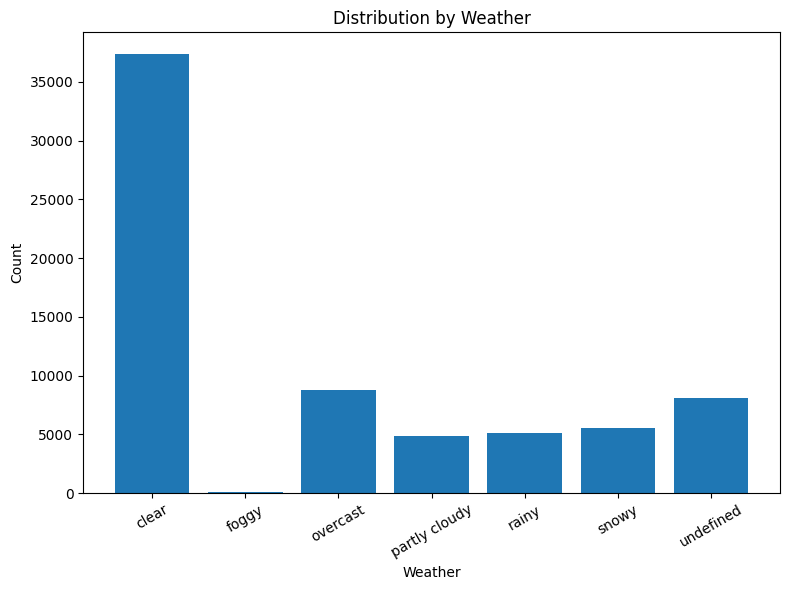

In [19]:
save_path = os.path.join(train_save_dir, "Distibution by Weather across Images.png")
plot_count(train_stats["image_wise"]["weather"], save_path)

#### Distibution by Scene across Images

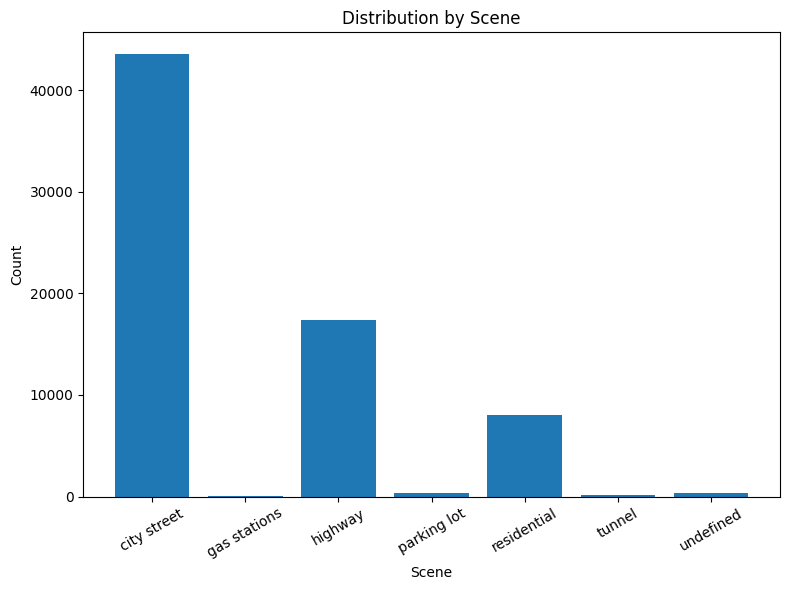

In [20]:
save_path = os.path.join(train_save_dir, "Distibution by Scene across Images.png")
plot_count(train_stats["image_wise"]["scene"], save_path)

#### Distibution by Time Of Day across Images

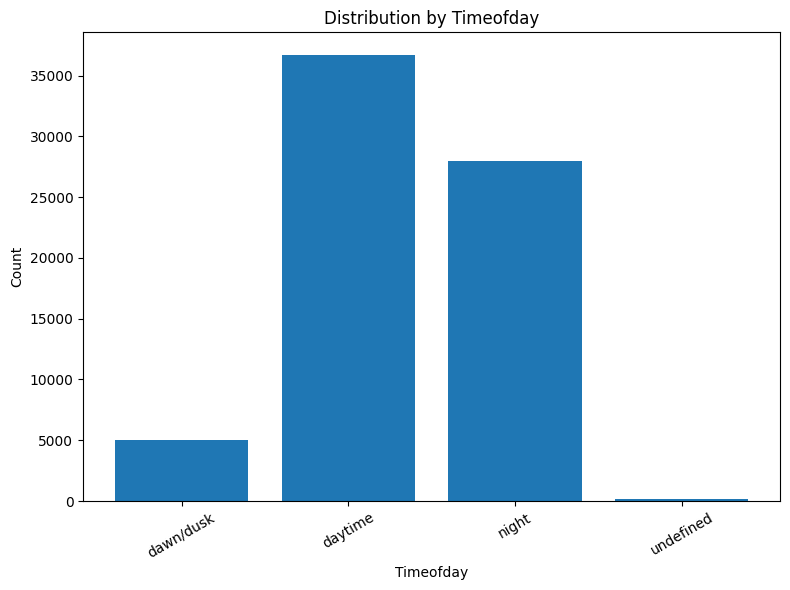

In [21]:
save_path = os.path.join(train_save_dir, "Distibution by Time Of Day across Images.png")
plot_count(train_stats["image_wise"]["time_of_day"], save_path)

### 7.2 Class-Wise Plots

#### Distibution by Weather across Class

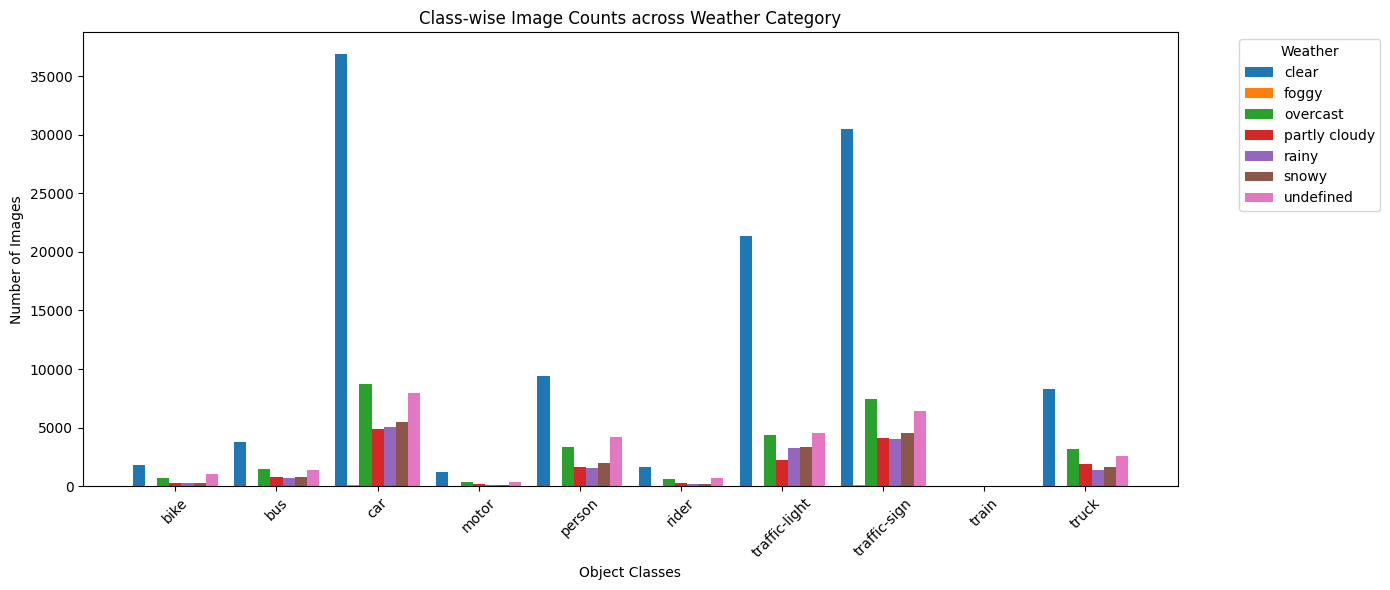

In [22]:
save_path = os.path.join(train_save_dir, "Distibution by Weather across Class.png")
plot_class_attribute_count("weather", *train_stats["class_wise"]["weather"], save_path)

#### Distibution by Scene across Class

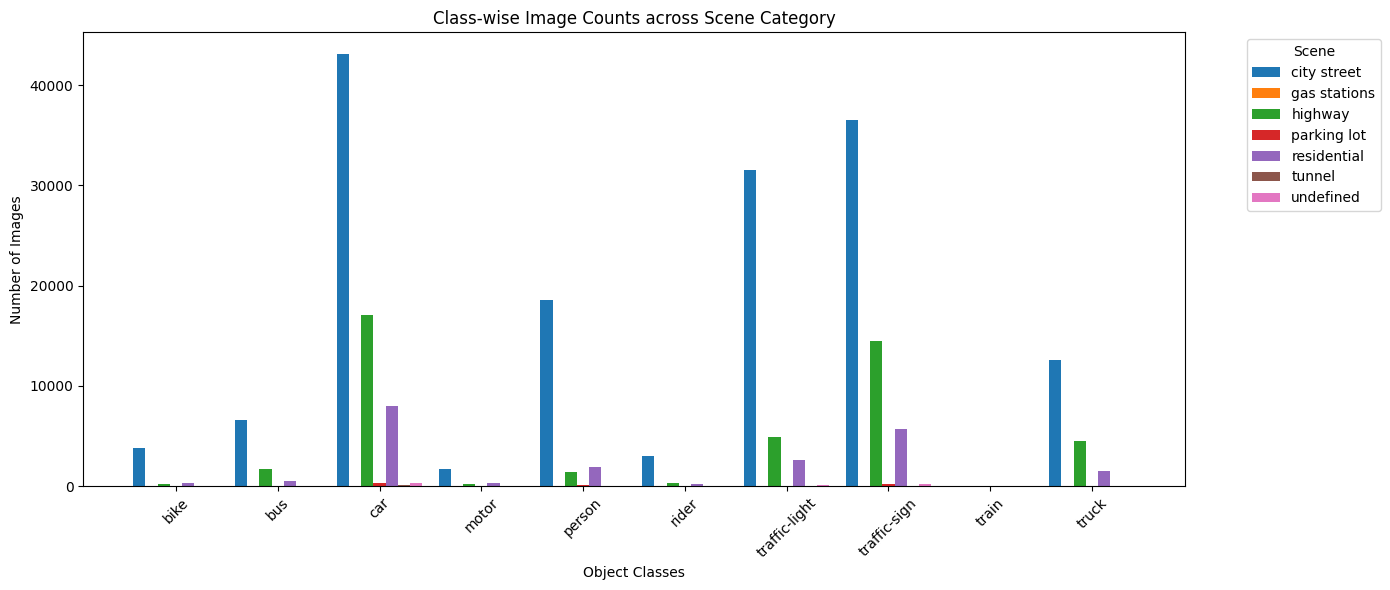

In [23]:
save_path = os.path.join(train_save_dir, "Distibution by Scene across Class.png")
plot_class_attribute_count("scene", *train_stats["class_wise"]["scene"], save_path)

#### Distibution by Time Of Day across Class

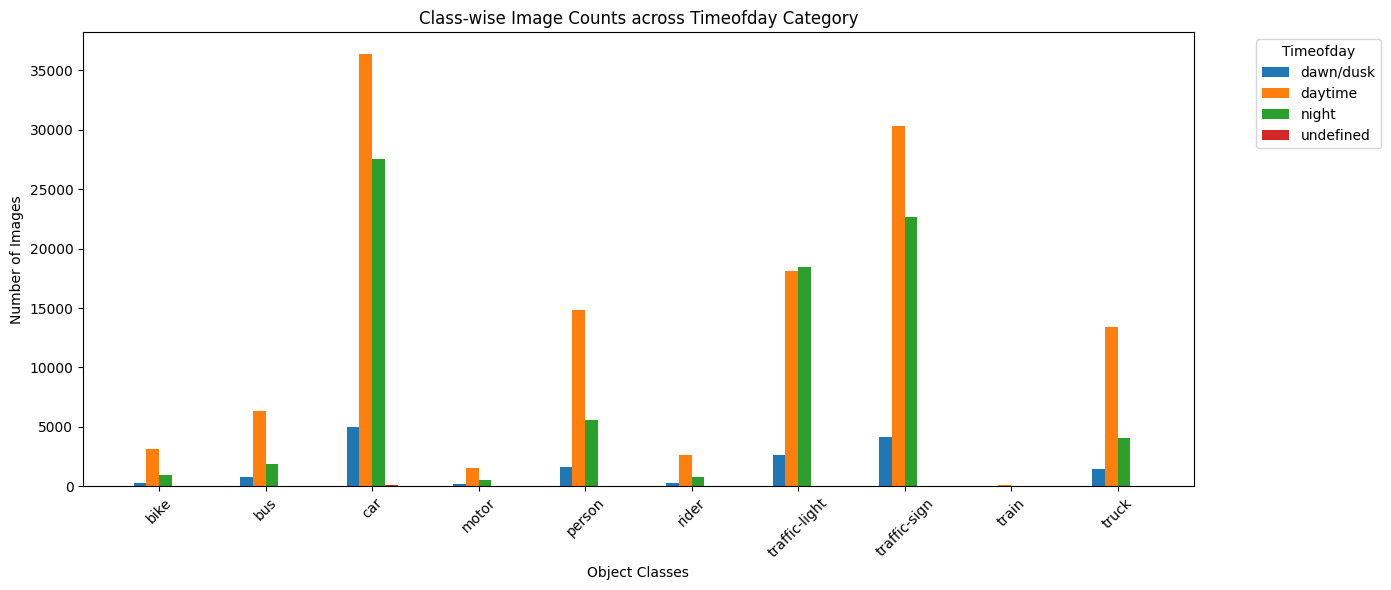

In [24]:
save_path = os.path.join(train_save_dir, "Distibution by Time Of Day across Class.png")
plot_class_attribute_count("timeofday", *train_stats["class_wise"]["time_of_day"], save_path)

### Label-Wise Plots

#### Distibution by Label across Labels 

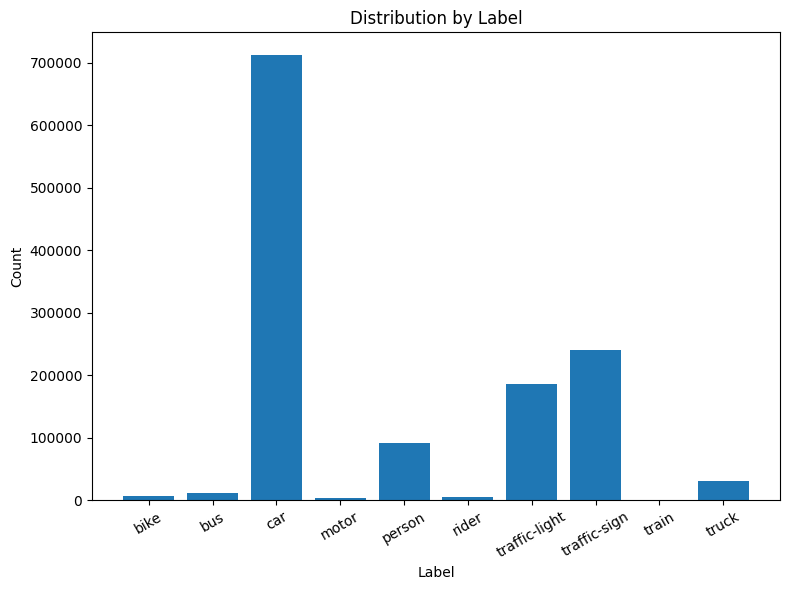

In [25]:
save_path = os.path.join(train_save_dir, "Distibution by Label across Labels.png")
plot_count(train_stats["label_wise"]["all_labels"], save_path)

#### Distibution by Occluded Labels across Labels 

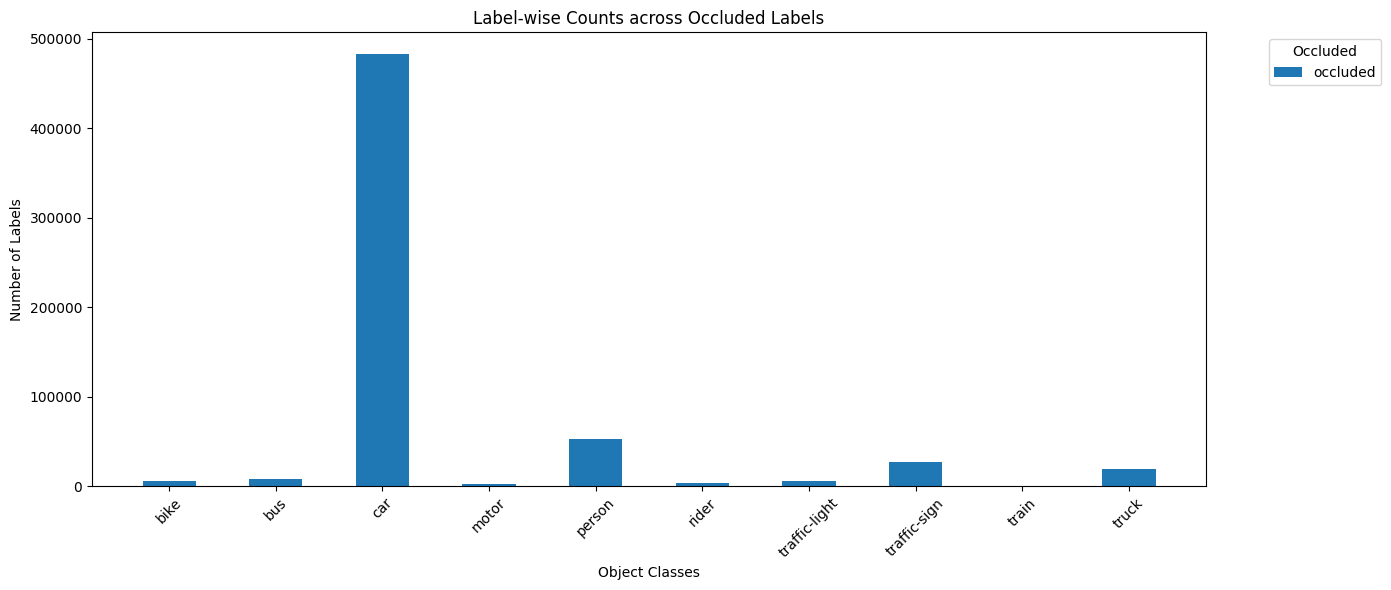

In [26]:
save_path = os.path.join(train_save_dir, "Distibution by Occluded Labels across Labels.png")
plot_label_attribute_count("occluded", train_stats["label_wise"]["occluded"], save_path)

#### Distibution by Truncated Labels across Labels 

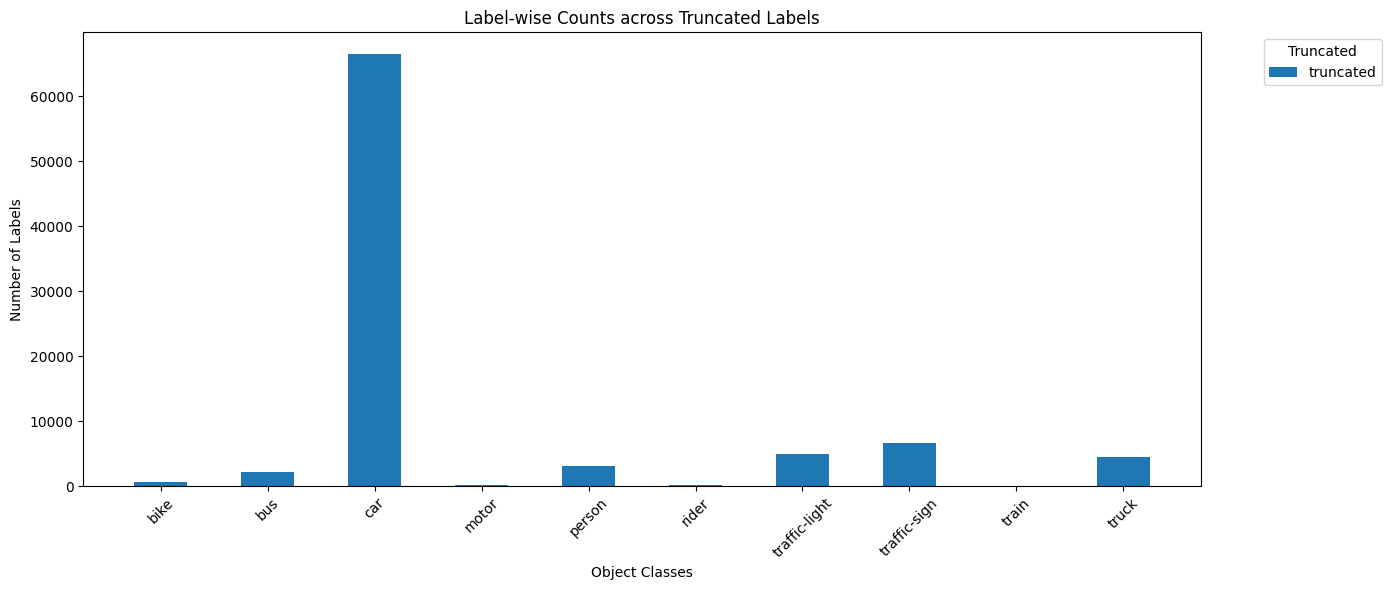

In [27]:
save_path = os.path.join(train_save_dir, "Distibution by Truncated Labels across Labels.png")
plot_label_attribute_count("truncated", train_stats["label_wise"]["truncated"], save_path)

#### Distibution by Small-Sized Labels across Labels 

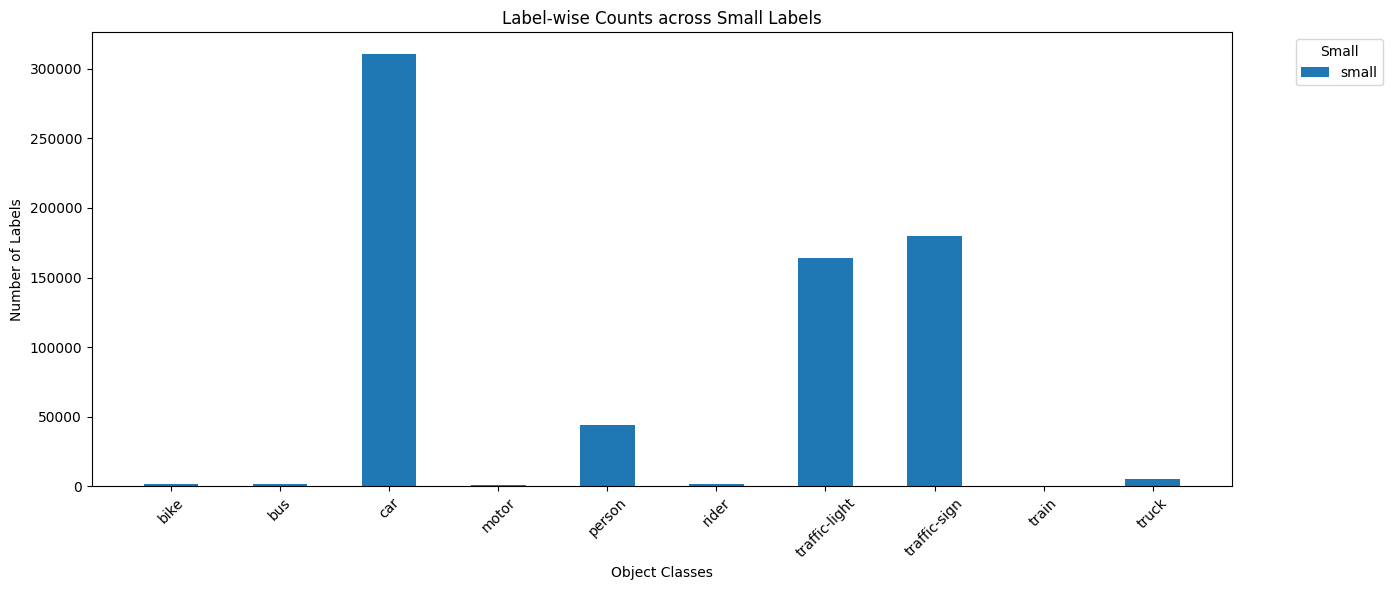

In [28]:
save_path = os.path.join(train_save_dir, "Distibution by Small-Sized Labels across Labels.png")
plot_label_attribute_count("small", train_stats["label_wise"]["small"], save_path)

#### Distibution by Medium-Sized Labels across Labels 

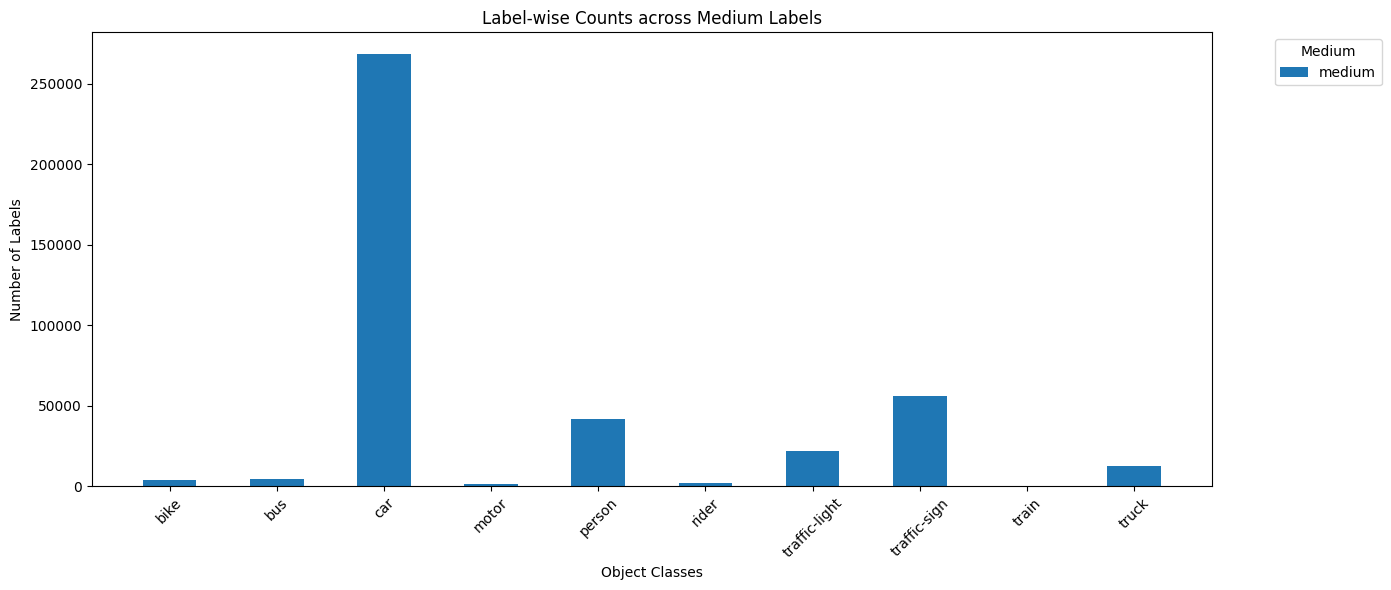

In [29]:
save_path = os.path.join(train_save_dir, "Distibution by Medium-Sized Labels across Labels.png")
plot_label_attribute_count("medium", train_stats["label_wise"]["medium"], save_path)

#### Distibution by Large-Sized Labels across Labels 

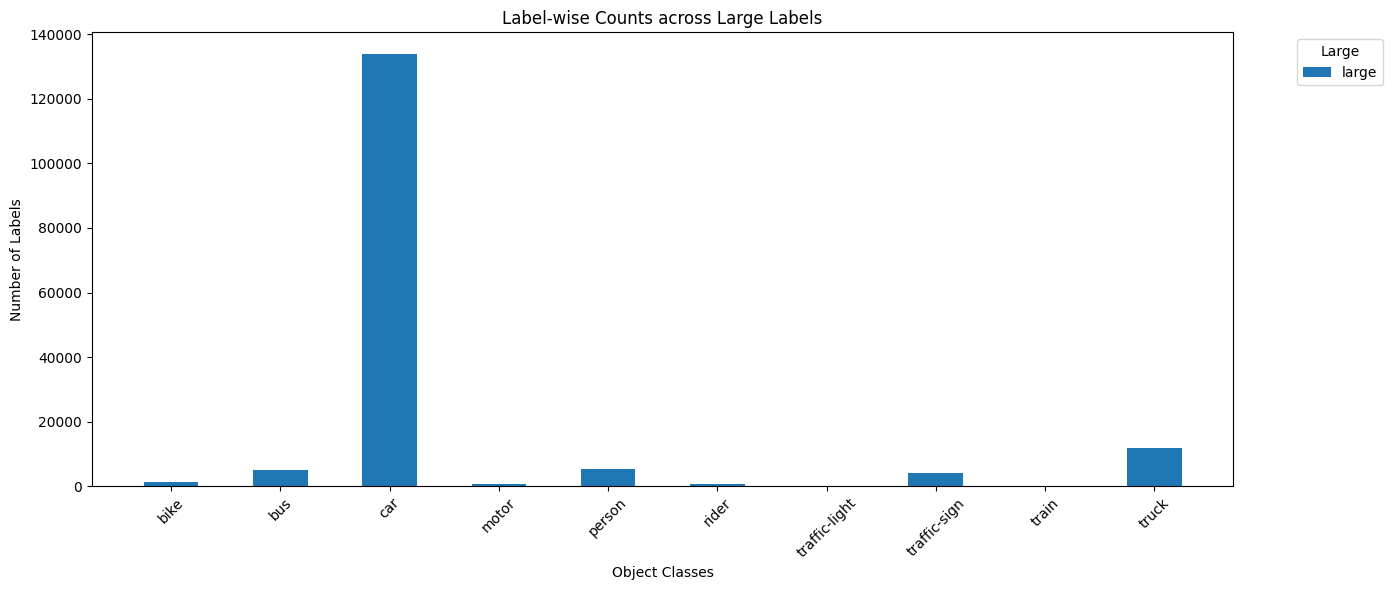

In [30]:
save_path = os.path.join(train_save_dir, "Distibution by Large-Sized Labels across Labels.png")
plot_label_attribute_count("large", train_stats["label_wise"]["large"], save_path)

#### Distibution by Uncertain Labels across Labels 

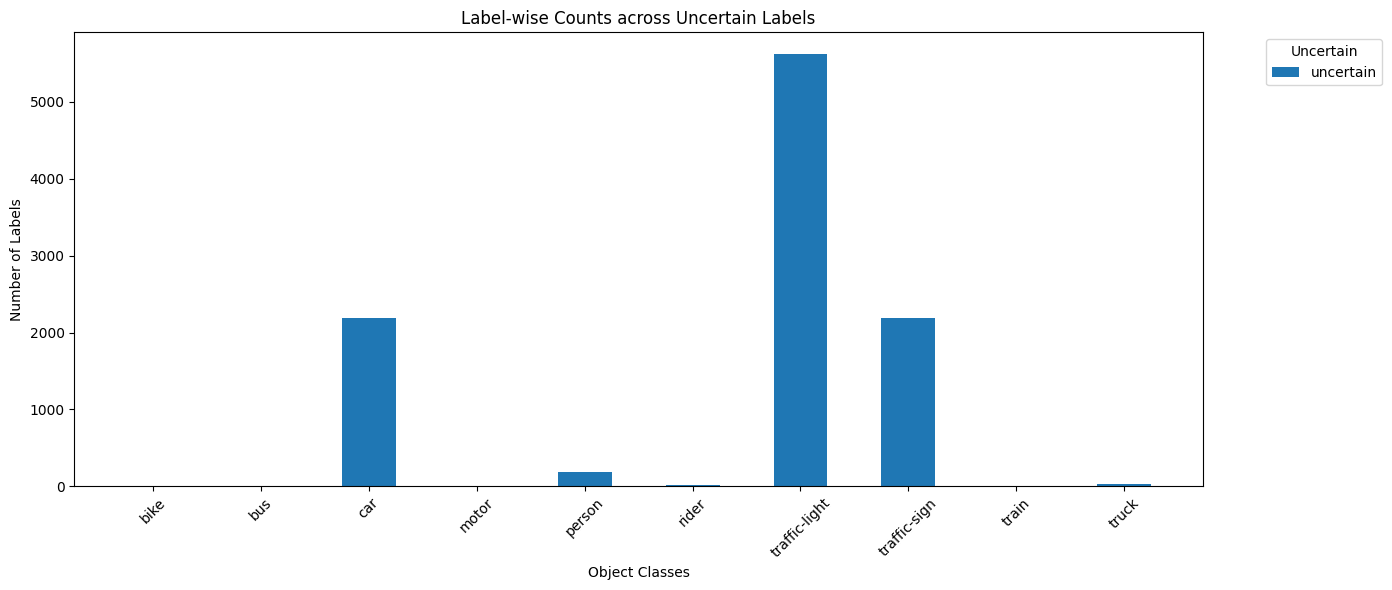

In [31]:
save_path = os.path.join(train_save_dir, "Distibution by Uncertain Labels across Labels.png")
plot_label_attribute_count("uncertain", train_stats["label_wise"]["uncertain"], save_path)

## 8. Plots Val

In [32]:
val_save_dir = os.path.join("plots", "val")
os.makedirs(val_save_dir, exist_ok=True)

### 8.1 Image-Wise Plots

#### Distibution by Weather across Images

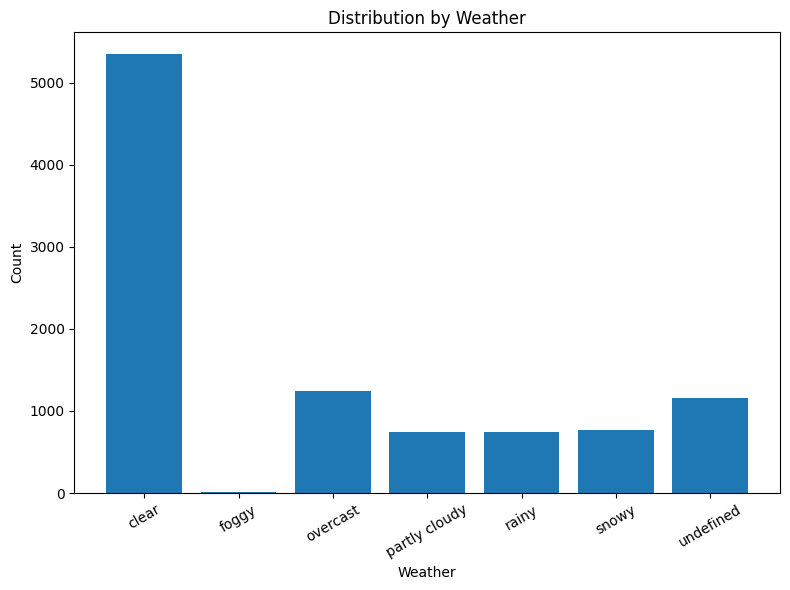

In [33]:
save_path = os.path.join(val_save_dir, "Distibution by Weather across Images.png")
plot_count(val_stats["image_wise"]["weather"], save_path)

#### Distibution by Scene across Images

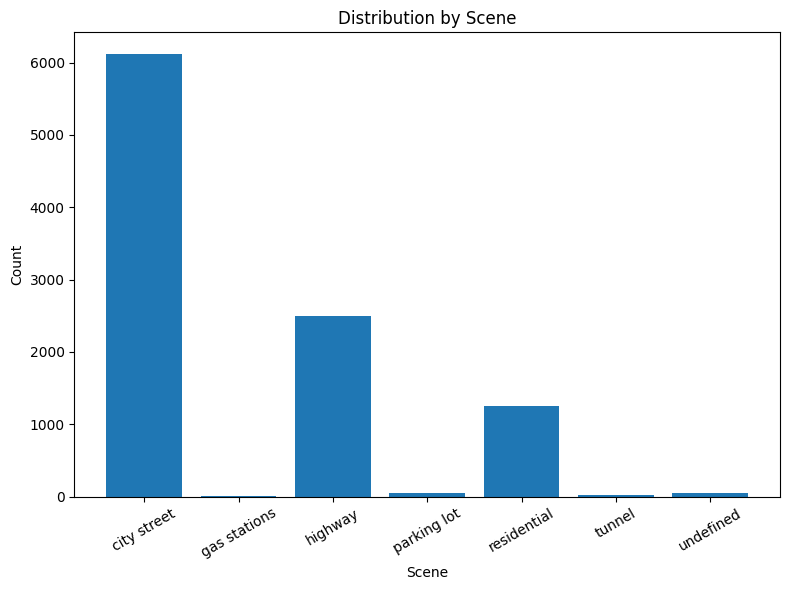

In [34]:
save_path = os.path.join(val_save_dir, "Distibution by Scene across Images.png")
plot_count(val_stats["image_wise"]["scene"], save_path)

#### Distibution by Time Of Day across Images

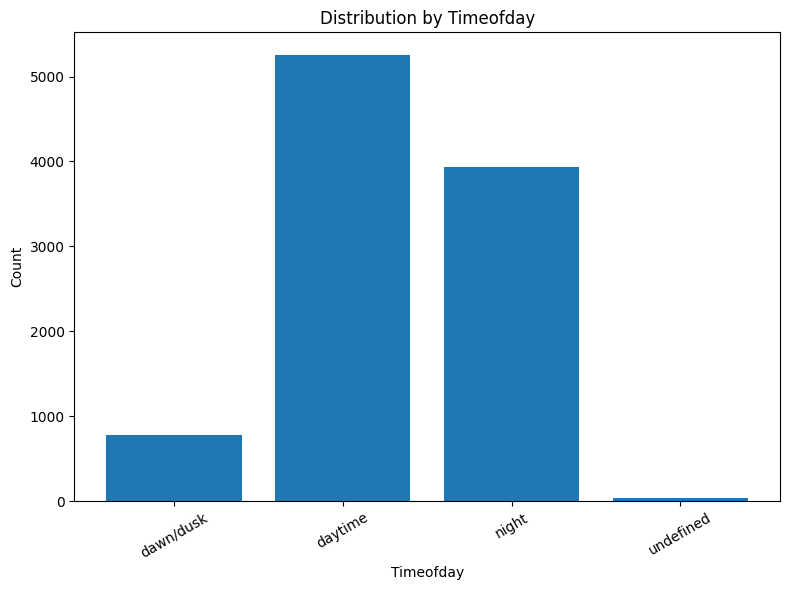

In [35]:
save_path = os.path.join(val_save_dir, "Distibution by Time Of Day across Images.png")
plot_count(val_stats["image_wise"]["time_of_day"], save_path)

### 8.2 Class-Wise Plots

#### Distibution by Weather across Class

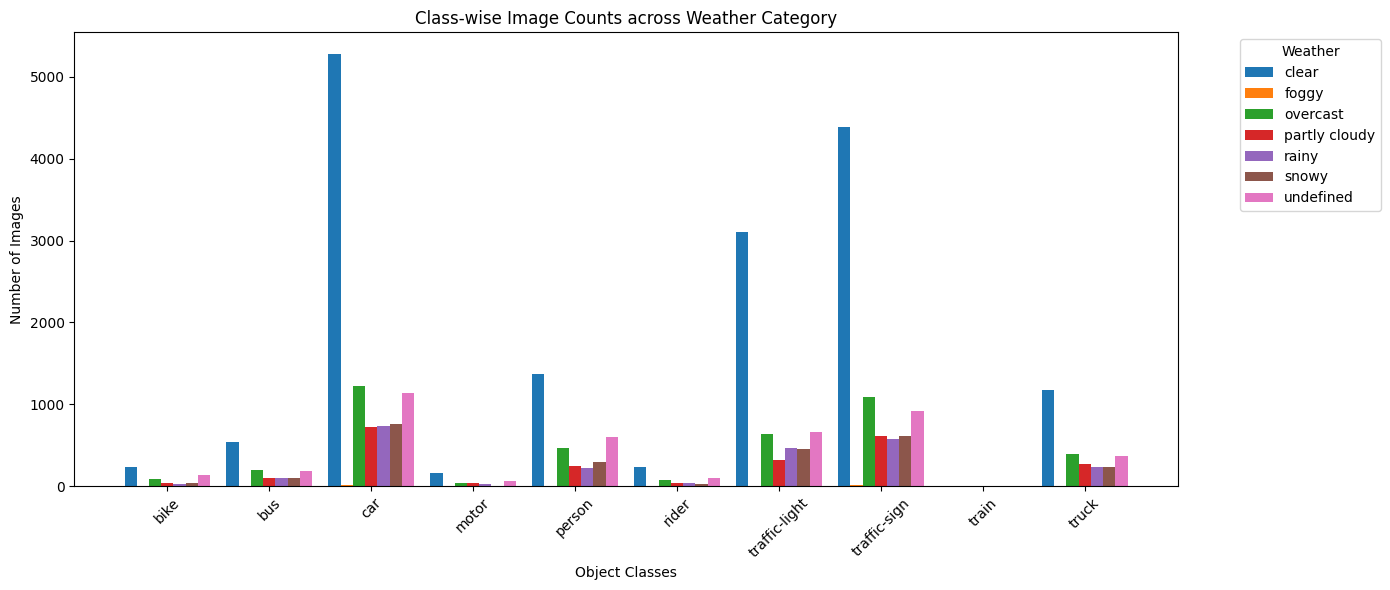

In [36]:
save_path = os.path.join(val_save_dir, "Distibution by Weather across Class.png")
plot_class_attribute_count("weather", *val_stats["class_wise"]["weather"], save_path)

#### Distibution by Scene across Class

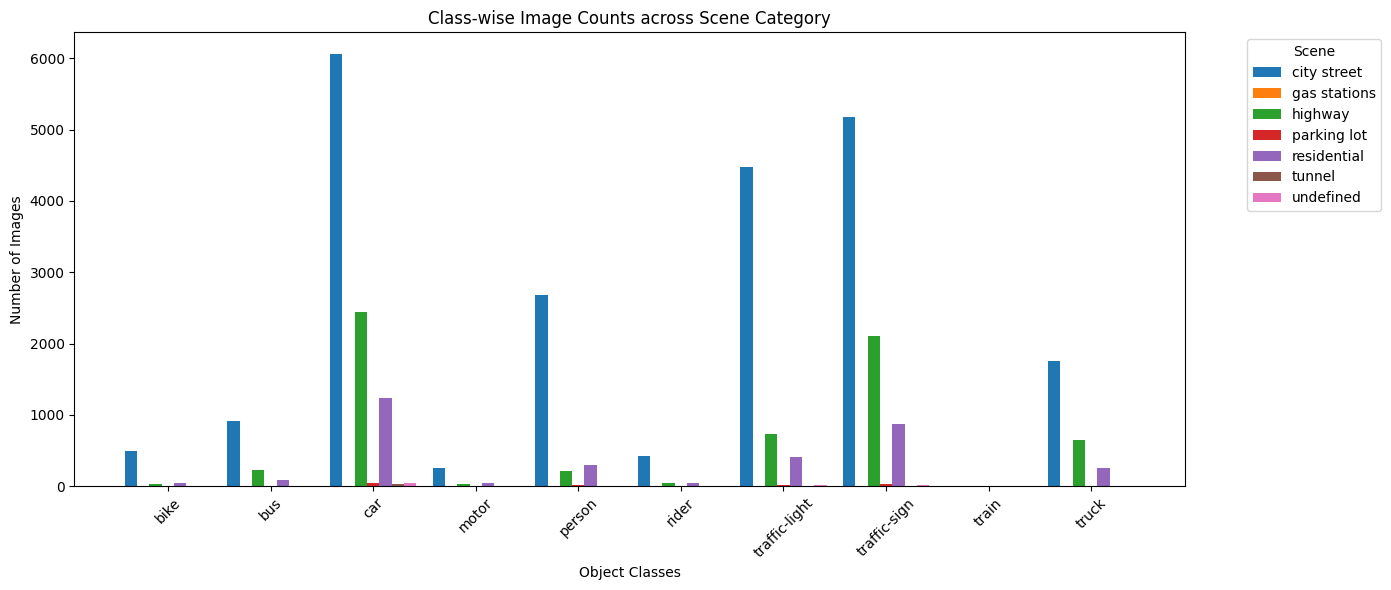

In [37]:
save_path = os.path.join(val_save_dir, "Distibution by Scene across Class.png")
plot_class_attribute_count("scene", *val_stats["class_wise"]["scene"], save_path)

#### Distibution by Time Of Day across Class

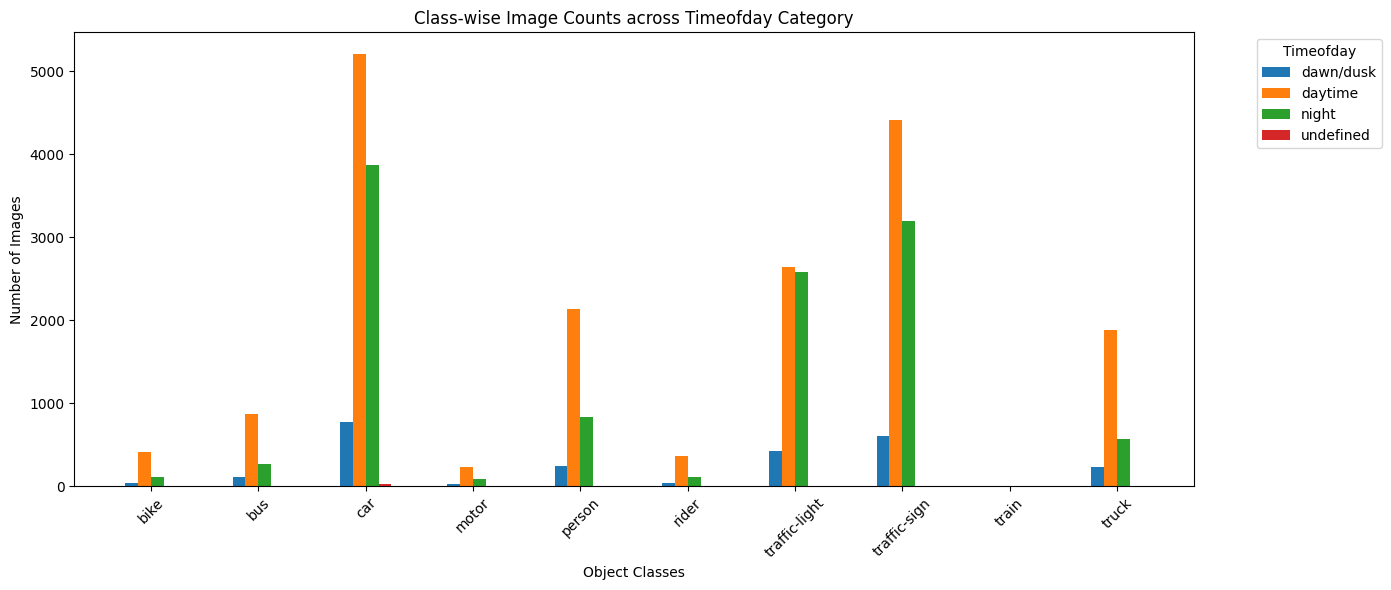

In [38]:
save_path = os.path.join(val_save_dir, "Distibution by Time Of Day across Class.png")
plot_class_attribute_count("timeofday", *val_stats["class_wise"]["time_of_day"], save_path)

### 8.3 Label-Wise Plots

#### Distibution by Label across Labels 

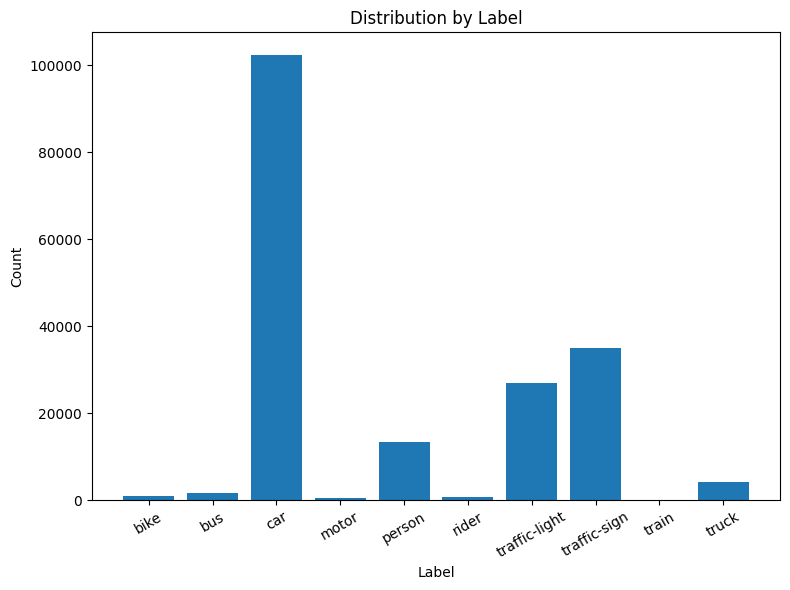

In [39]:
save_path = os.path.join(val_save_dir, "Distibution by Label across Labels.png")
plot_count(val_stats["label_wise"]["all_labels"], save_path)

#### Distibution by Occluded Labels across Labels 

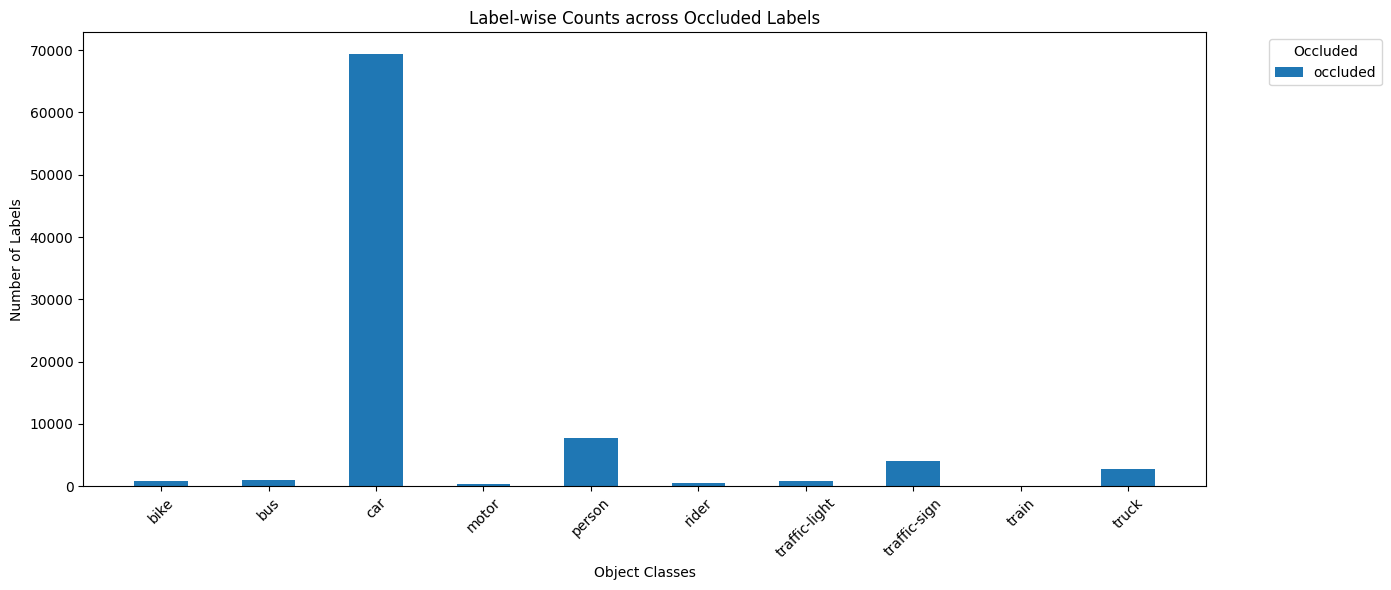

In [40]:
save_path = os.path.join(val_save_dir, "Distibution by Occluded Labels across Labels.png")
plot_label_attribute_count("occluded", val_stats["label_wise"]["occluded"], save_path)

#### Distibution by Truncated Labels across Labels 

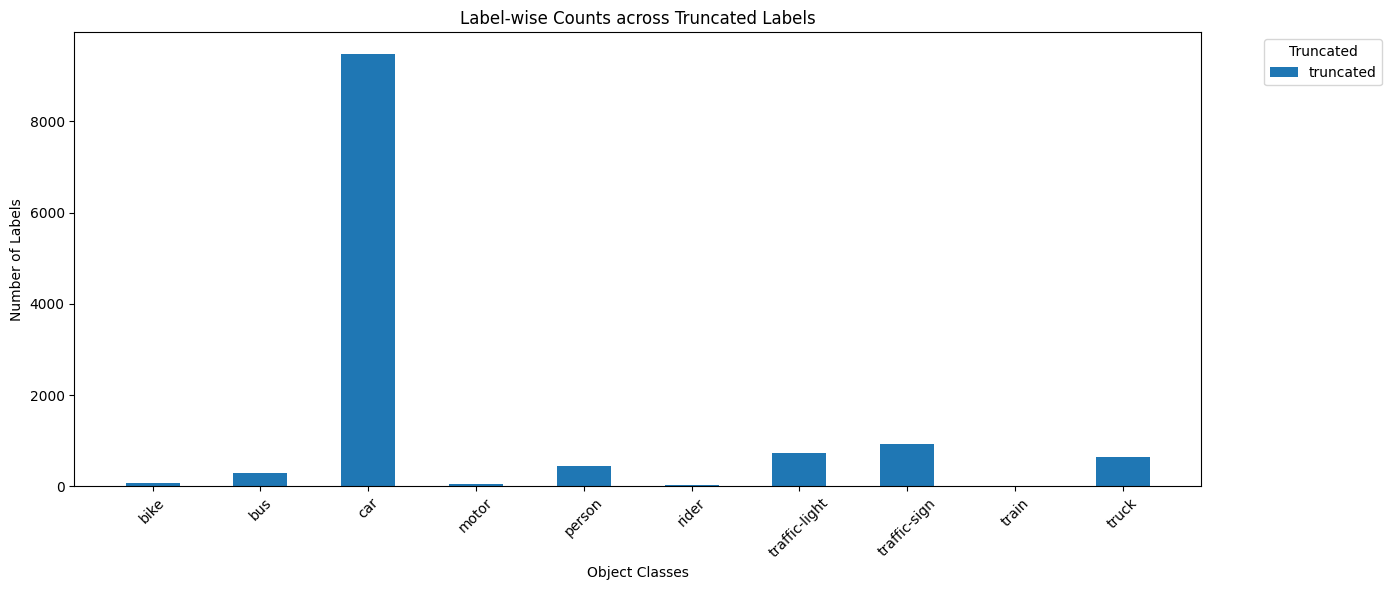

In [41]:
save_path = os.path.join(val_save_dir, "Distibution by Truncated Labels across Labels.png")
plot_label_attribute_count("truncated", val_stats["label_wise"]["truncated"], save_path)

#### Distibution by Small-Sized Labels across Labels 

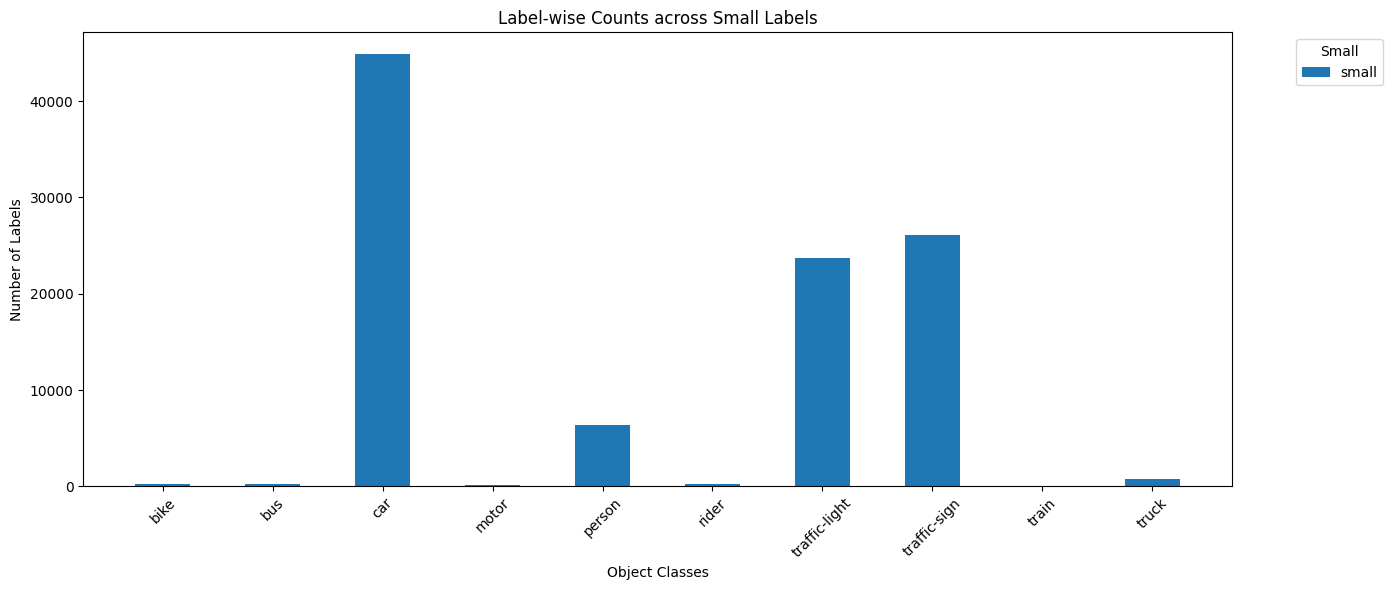

In [42]:
save_path = os.path.join(val_save_dir, "Distibution by Small-Sized Labels across Labels.png")
plot_label_attribute_count("small", val_stats["label_wise"]["small"], save_path)

#### Distibution by Medium-Sized Labels across Labels 

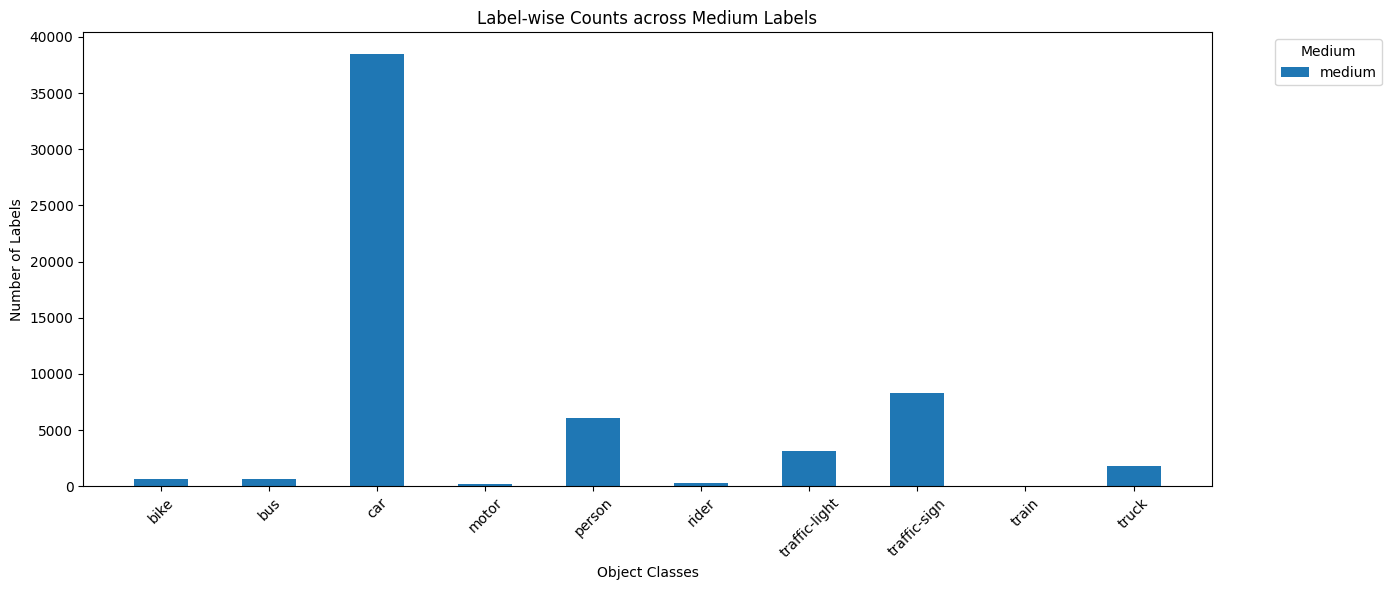

In [43]:
save_path = os.path.join(val_save_dir, "Distibution by Medium-Sized Labels across Labels.png")
plot_label_attribute_count("medium", val_stats["label_wise"]["medium"], save_path)

#### Distibution by Large-Sized Labels across Labels 

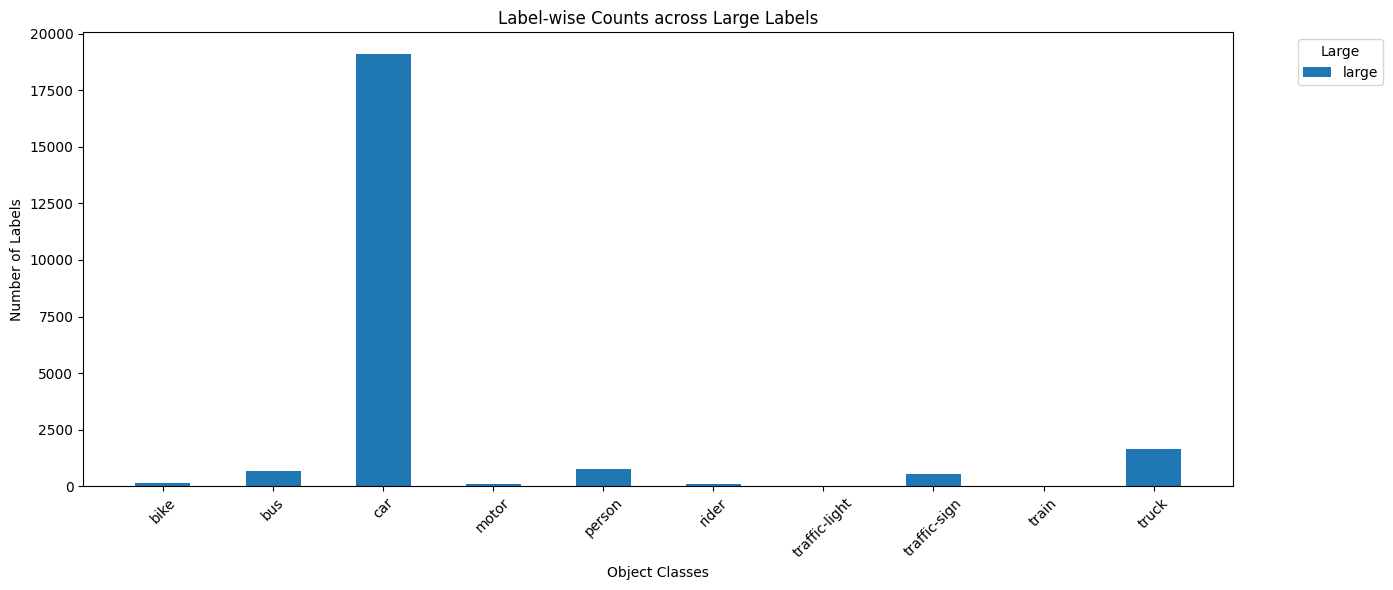

In [44]:
save_path = os.path.join(val_save_dir, "Distibution by Large-Sized Labels across Labels.png")
plot_label_attribute_count("large", val_stats["label_wise"]["large"], save_path)

## 9. Plots Uncertain

Referring to the defined uncertain conditions; <br/>
Objects A ["traffic-sign", "traffic-light", "person", "bike", "rider", "motor"] which have an area > 512^2 are Uncertain! <br/>
Objects B ["car", "bus", "truck", "train"] which have an area < 8^2 are Uncertain! <br/>

-> Ideally these mentioned objects should have area < 512^2 <br/>
-> So lets see if <br/>

Condition a) any of objects A have area > 512^2 (i.e uncertain) <br/>
Condition b) any of objects B have an area < 8^2 (i.e uncertain)

In [45]:
possible_uncertain_objects_a = ["traffic-sign", "traffic-light", "person", "bike", "rider", "motor"]
possible_uncertain_objects_b = ["car", "bus", "truck", "train"]

## Train

#### Distibution by Uncertain Labels across Labels 

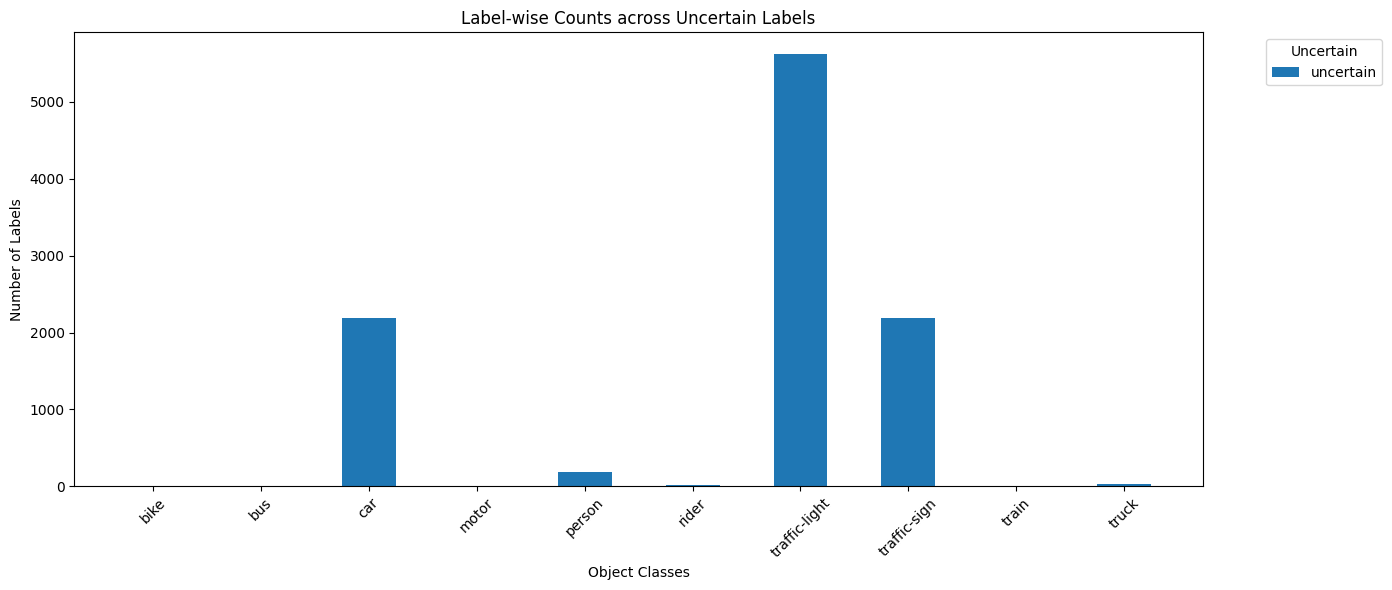

In [46]:
save_path = os.path.join(train_save_dir, "Distibution by Uncertain Labels across Labels.png")
plot_label_attribute_count("uncertain", train_stats["label_wise"]["uncertain"], save_path)

In [47]:
# a) any of these objects have area > 512^2 (i.e uncertain)
train_label_df.query(f"uncertain == True and area > {512**2} and label in @possible_uncertain_objects_a")

,file_name,weather,scene,timeofday,label,occluded,truncated,uncertain,small,medium,large,area,bbox
148596,14e578d7-c17a7d22.jpg,clear,city street,daytime,traffic-sign,False,False,True,False,False,True,323744.664585,"[663.661479, 44.45429, 1224.834594, 621.36123]"
194035,1af55d81-20ae3997.jpg,snowy,residential,daytime,traffic-sign,False,True,True,False,False,True,366157.526847,"[303.153514, 167.567427, 1096.10126, 629.334963]"
209187,1d33c83b-71e1ea1c.jpg,clear,city street,daytime,traffic-sign,True,False,True,False,False,True,917709.770977,"[0, 1.836272, 1279.269409, 719.206487]"
335347,2e5a3ced-c7603d0d.jpg,undefined,highway,dawn/dusk,traffic-sign,False,False,True,False,False,True,906063.364897,"[0, 2.495509, 1273.956878, 713.715316]"
419817,39fba3aa-43b709f1.jpg,overcast,city street,daytime,traffic-sign,False,True,True,False,False,True,299441.312472,"[427.228869, 3.061418, 1215.593481, 382.887336]"
450270,3e1a7d8e-216344b5.jpg,undefined,city street,daytime,bike,True,True,True,False,False,True,273027.062523,"[739.375131, 92.856768, 1248.589668, 629.029722]"
582431,50f67560-2369bf34.jpg,clear,city street,daytime,person,False,True,True,False,False,True,267082.913278,"[838.22266, 1.49769, 1278.543464, 608.062065]"
747538,67c7bea2-283d3be6.jpg,clear,city street,night,traffic-light,False,True,True,False,False,True,302654.309631,"[1.500534, 2.693635, 559.025563, 545.546949]"
926365,80a7aded-61288b3d.jpg,snowy,city street,dawn/dusk,motor,False,True,True,False,False,True,316440.638899,"[700.657379, 145.969028, 1277.245012, 694.785237]"
1029498,8edb33ee-ec1bc2e0.jpg,overcast,city street,daytime,traffic-light,False,False,True,False,False,True,294183.100268,"[1.469383, 1.469383, 452.38796, 653.877856]"


#### We have 13 rows with labels in ["traffic-sign", "traffic-light", "person", "bike", "rider", "motor"] having area > 512^2

#### There are high chances that these are mislabeled!

In [50]:
# b) any of objects (except objects (a)) have an area < 8^2 (i.e uncertain)
train_label_df.query(f"uncertain == True and area < {8**2} and label in @possible_uncertain_objects_b")

,file_name,weather,scene,timeofday,label,occluded,truncated,uncertain,small,medium,large,area,bbox
892,002685b6-856c17f7.jpg,overcast,residential,daytime,car,True,False,True,True,False,False,53.778429,"[666.253834, 475.022418, 672.241513, 484.003933]"
893,002685b6-856c17f7.jpg,overcast,residential,daytime,car,True,False,True,True,False,False,53.778411,"[682.506116, 476.020365, 688.493793, 485.00188]"
2154,00589f25-4cf2b9e0.jpg,undefined,city street,daytime,car,True,False,True,True,False,False,63.789757,"[663.906944, 354.216817, 671.893792, 362.203667]"
2886,006fdb67-a1455b77.jpg,undefined,city street,daytime,car,True,False,True,True,False,False,43.739884,"[21.903697, 353.828954, 31.638674, 358.322019]"
3606,007c11bf-f6da335c.jpg,partly cloudy,highway,daytime,car,True,False,True,True,False,False,58.295767,"[371.387922, 239.693985, 380.204253, 246.306233]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1284188,b1b00a82-179c3c63.jpg,overcast,city street,daytime,car,True,False,True,True,False,False,53.437749,"[594.151794, 261.183793, 606.274247, 265.591956]"
1284382,b1bc61a3-fff49994.jpg,undefined,city street,daytime,car,True,False,True,True,False,False,63.708675,"[794.92513, 270.684675, 803.232821, 278.353313]"
1284539,b1bea966-e9bd6f08.jpg,clear,city street,dawn/dusk,car,False,True,True,True,False,False,13.444621,"[1242.467062, 630.226746, 1246.957822, 633.220..."
1285810,fdf00ecc-0f09e2b4.jpg,rainy,city street,daytime,car,True,False,True,True,False,False,54.774324,"[698.895048, 410.1559, 709.872456, 415.145632]"


#### Oh! we have 2221 rows with labels in ["car", "bus", "truck", "train"] having area < 8^2

## Val

#### Distibution by Uncertain Labels across Labels 

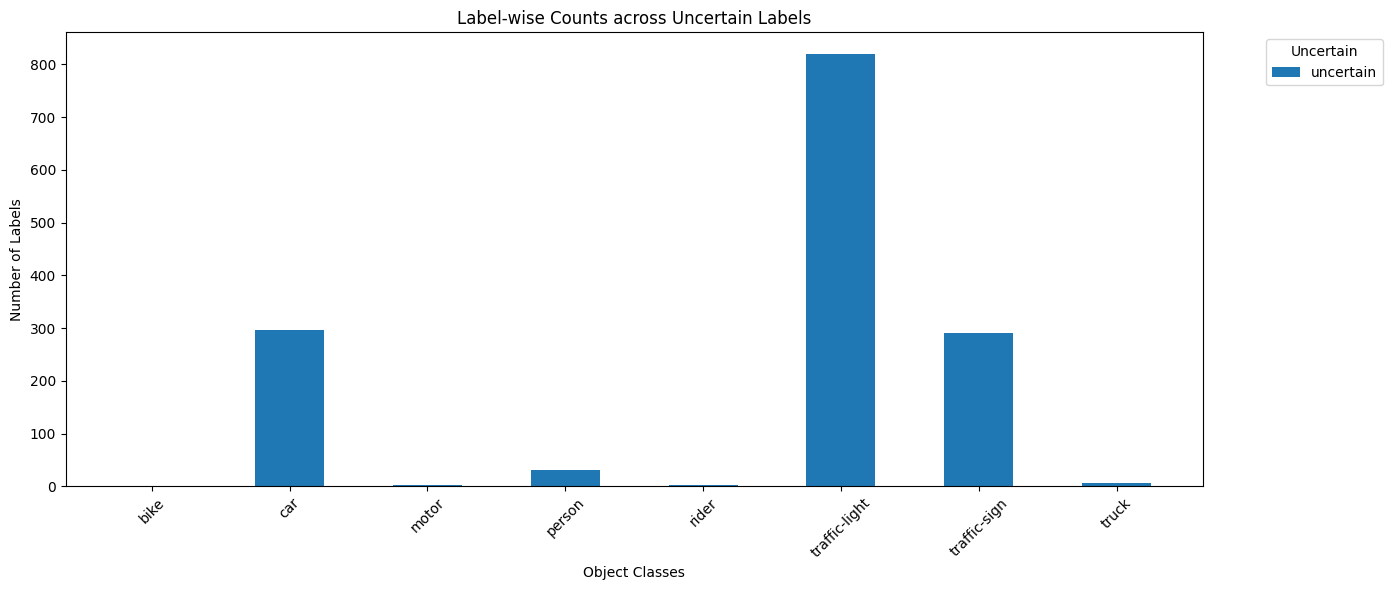

In [51]:
save_path = os.path.join(val_save_dir, "Distibution by Uncertain Labels across Labels.png")
plot_label_attribute_count("uncertain", val_stats["label_wise"]["uncertain"], save_path)

In [52]:
# a) any of these objects have area > 512^2 (i.e uncertain)
val_label_df.query(f"uncertain == True and area > {512**2} and label in @possible_uncertain_objects_a")

,file_name,weather,scene,timeofday,label,occluded,truncated,uncertain,small,medium,large,area,bbox


##### Awesome! we do not have any uncertain rows with condition a)

In [53]:
# b) any of objects (except objects (a)) have an area < 8^2 (i.e uncertain)
val_label_df.query(f"uncertain == True and area < {8**2} and label in @possible_uncertain_objects_b")

,file_name,weather,scene,timeofday,label,occluded,truncated,uncertain,small,medium,large,area,bbox
838,b1d968b9-ce42734f.jpg,overcast,highway,dawn/dusk,car,False,False,True,True,False,False,62.741494,"[583.798543, 375.227781, 592.780059, 382.213405]"
987,b1df722f-5bcc3db7.jpg,clear,highway,daytime,car,True,False,True,True,False,False,35.852273,"[485.001865, 334.561472, 496.97722, 337.55531]"
995,b1df722f-5bcc3db7.jpg,clear,highway,daytime,car,False,False,True,True,False,False,19.917930,"[516.936145, 333.563526, 518.932037, 343.542989]"
1069,b1e1a7b8-b397c445.jpg,rainy,city street,daytime,car,True,False,True,True,False,False,11.988938,"[340.730379, 445.601885, 342.362619, 452.946968]"
1302,b1f022d3-3774de8b.jpg,undefined,city street,daytime,car,True,False,True,True,False,False,47.266066,"[500.17462, 348.192947, 506.605624, 355.542665]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
182845,ca1a87ef-4f83ae99.jpg,clear,city street,night,car,True,False,True,True,False,False,57.901142,"[653.491401, 351.457561, 660.081232, 360.243999]"
182848,ca1a87ef-4f83ae99.jpg,clear,city street,night,car,True,False,True,True,False,False,60.313699,"[671.064279, 351.457561, 676.555805, 362.44061]"
183884,ca3165e0-3a330c98.jpg,clear,city street,night,car,True,False,True,True,False,False,50.642196,"[731.297032, 254.484019, 749.671331, 257.240162]"
185069,ca656c47-876ad414.jpg,clear,city street,daytime,car,True,False,True,True,False,False,63.737390,"[564.837565, 441.092232, 572.821135, 449.075802]"


##### Oh! we have 303 rows with labels in ["car", "bus", "truck", "train"] having area < 8^2

# [Optional] Visualize Uncertain objects

In [54]:
images_dir = os.path.join("data", "bdd100k_images_100k", "bdd100k", "images", "100k", "train")

#### Possibly Mislabeled! (uncertain)

In [56]:
mislabeled_df = train_label_df.query(f"uncertain == True and area > {512**2} and label in @possible_uncertain_objects_a")
file_names = mislabeled_df["file_name"].unique().tolist()

GT Label: traffic-sign


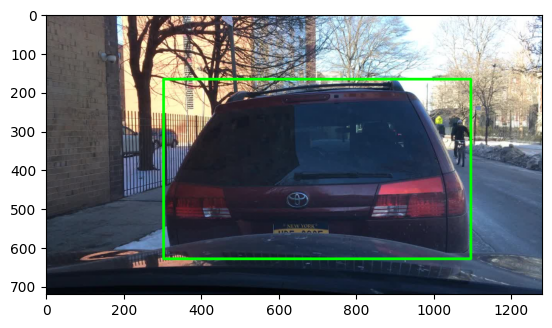

In [62]:
random_idx = np.random.randint(0, len(file_names))

file_name = file_names[random_idx]
bboxes = mislabeled_df.query("file_name == @file_name")["bbox"].tolist()
labels = mislabeled_df.query("file_name == @file_name")["label"].tolist()

image_file = os.path.join(images_dir, file_name)
image = cv2.cvtColor(cv2.imread(image_file), cv2.COLOR_BGR2RGB)

for i, bbox in enumerate(bboxes):
    cv2.rectangle(image, (int(bbox[0]), int(bbox[1])), (int(bbox[2]), int(bbox[3])), (0, 255, 0), 5)
    print("GT Label:", labels[i])
    
plt.imshow(image)

#### Extremely Small (uncertain)

In [63]:
undertain_df = train_label_df.query(f"uncertain == True and area < {8**2} and label in @possible_uncertain_objects_b")
file_names = undertain_df["file_name"].unique().tolist()

car
car
car
car


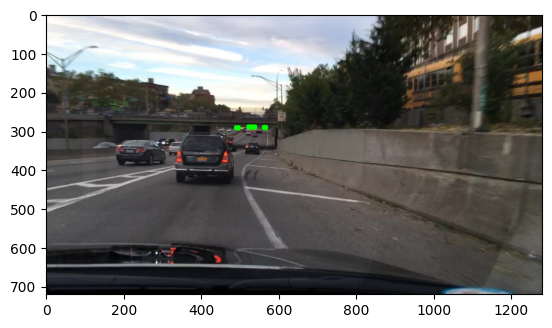

In [68]:
random_idx = np.random.randint(0, len(file_names))

file_name = file_names[random_idx]
bboxes = undertain_df.query("file_name == @file_name")["bbox"].tolist()
labels = undertain_df.query("file_name == @file_name")["label"].tolist()

image_file = os.path.join(images_dir, file_name)
image = cv2.cvtColor(cv2.imread(image_file), cv2.COLOR_BGR2RGB)

for i, bbox in enumerate(bboxes):
    cv2.rectangle(image, (int(bbox[0]), int(bbox[1])), (int(bbox[2]), int(bbox[3])), (0, 255, 0), 5)
    print(labels[i])
    
plt.imshow(image)